# Projeto de PO-233 
Este projeto busca realizar análise do problema proposto pelo Data Science Challenge 2019 - ITA.

##### Alunos:
- Fernando Zanchitta
- Davi Xie
- Hugo Timóteo

##### Dados
Os dados podem ser adquiridos no site: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

## Introdução

O campo do aprendizado de máquina e da ciência de dados tem se mostrado cada vez mais relevante e aplicável em diversas áreas. Entre as áreas de grande interesse encontra-se a precificação de imóveis residenciais, um desafio que envolve a análise de várias características do imóvel e a estimativa do seu valor de mercado. Essa é uma tarefa complexa, devido à grande quantidade de fatores que influenciam o problema. Características como tamanho, localização, qualidade, idade, entre outras, desempenham um papel fundamental na determinação do preço de venda. No entanto, a relação entre essas características e o preço não é linear e muitas vezes não é facilmente mensurável. Além disso, existem fatores externos e tendências de mercado que também impactam o valor dos imóveis. Portanto, é um desafio desenvolver modelos que sejam capazes de estimar com precisão os preços de venda.

Com base nisso, objetivo deste trabalho é explorar o uso de técnicas de aprendizado indutivo, análise exploratória de dados e aprendizado preditivo para construir um modelo de regressão capaz de estimar o preço de venda de imóveis residenciais. Para isso, utilizaremos o conjunto de dados "House Prices - Advanced Regression Techniques", que contém informações detalhadas sobre características dos imóveis, como tamanho, localização, qualidade, idade, entre outras.

A fim de se alcançar o objetivo proposto, inicialmente será realizda uma análise exploratória dos dados, aplicando estatísticas descritivas e visualização multivariada para compreender a distribuição e relação entre as variáveis do conjunto de dados. Em seguida, faremos o pré-processamento dos dados, incluindo limpeza, redução dimensional e transformações, a fim de preparar os dados para a construção do modelo de regressão. Em sequência, serão utilizadas técnicas de aprendizado preditivo para treinar e avaliar diferentes modelos de regressão, utilizando métricas de desempenho adequadas para a tarefa de precificação de imóveis. Por fim, serão avaliadas a capacidade de generalização dos modelos por meio de validação cruzada e análise das métricas de erro.



### Descrição da base de dados



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.impute import KNNImputer
import functions

In [2]:
import os
print(os.getcwd())

C:\Users\Davi\Documents\ITA\PO-233\DSChallenge2019\src


In [3]:

train = pd.read_csv('../dataset/train.csv', index_col = 'Id')
test= pd.read_csv('../dataset/test.csv', index_col = 'Id')

In [4]:
train.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Pré-Processamento

## Remover Dados Faltantes:

<Axes: >

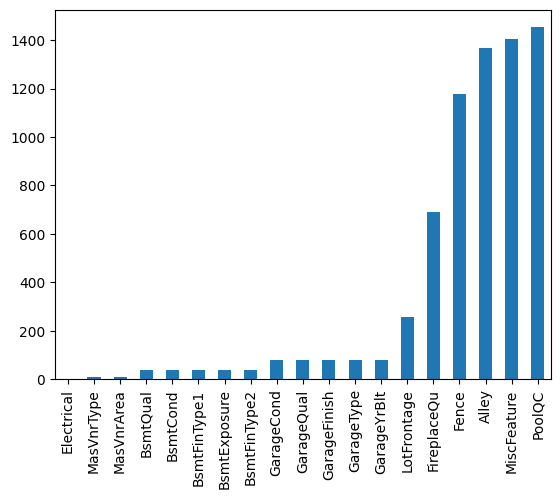

In [5]:
# Exibir os atributos com dados faltantes
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [6]:
# check missing values:

missing_values = pd.DataFrame(data={
    'Feature_name': train.columns,
    'missing_values': train.isnull().sum(),
    'percentage': train.isnull().sum() / len(train) * 100,
    'type': train.dtypes
})
missing_values.sort_values(by='percentage', ascending=False).head(20)

,Feature_name,missing_values,percentage,type
PoolQC,PoolQC,1453,99.520548,object
MiscFeature,MiscFeature,1406,96.301370,object
Alley,Alley,1369,93.767123,object
Fence,Fence,1179,80.753425,object
FireplaceQu,FireplaceQu,690,47.260274,object
LotFrontage,LotFrontage,259,17.739726,float64
GarageYrBlt,GarageYrBlt,81,5.547945,float64
GarageCond,GarageCond,81,5.547945,object
GarageType,GarageType,81,5.547945,object
GarageFinish,GarageFinish,81,5.547945,object


In [7]:
#remover colunas com mais de 50% de valores faltantes:
features_to_drop = missing_values[missing_values['percentage'] > 50]['Feature_name'].values
train = train.drop(features_to_drop, axis='columns')
test = test.drop(features_to_drop, axis='columns')


In [8]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500


## Atributos redundantes

In [9]:
# contagem de valores únicos:
unique_values = pd.DataFrame(data={"Feature_name": train.columns, "unique_values": train.nunique()})

In [10]:
unique_values.sort_values(by='unique_values', ascending=True).head(20)

,Feature_name,unique_values
CentralAir,CentralAir,2
Street,Street,2
Utilities,Utilities,2
HalfBath,HalfBath,3
PavedDrive,PavedDrive,3
BsmtHalfBath,BsmtHalfBath,3
LandSlope,LandSlope,3
GarageFinish,GarageFinish,3
Fireplaces,Fireplaces,4
LotShape,LotShape,4


Não temos nenhum atributo com valores únicos que possa ser descartado a priori

# Análise Exploratória

A análise exploratória de dados é um processo inicial na análise de dados, no qual o objetivo é obter uma compreensão básica dos dados e identificar padrões e tendências. É uma etapa crucial antes de aplicar técnicas estatísticas mais avançadas ou construir modelos preditivos.

#### Análise Exploratória para Dados Quantitativos:
Para dados quantitativos, que envolvem medições numéricas, a análise exploratória geralmente envolve os seguintes aspectos:

- Resumo estatístico: Calculam-se medidas estatísticas como média, mediana, moda, desvio padrão, mínimo, máximo e quartis. Essas medidas fornecem uma visão geral das características centrais, dispersão e distribuição dos dados.

- Visualização de dados: Utilizam-se gráficos e visualizações adequados para representar os dados quantitativos. Isso pode incluir histogramas, box plots, gráficos de dispersão, gráficos de linha ou gráficos de séries temporais, dependendo da natureza dos dados e do objetivo da análise.

- Análise de correlação: Explora-se a relação entre diferentes variáveis quantitativas por meio de medidas de correlação, como o coeficiente de correlação de Pearson. Isso ajuda a identificar a força e a direção da relação entre as variáveis.

- Identificação de outliers: Busca-se identificar valores atípicos ou discrepantes nos dados quantitativos. Isso pode ser feito por meio da análise de box plots, cálculo de limites de valores extremos ou utilizando métodos estatísticos para detectar observações fora do padrão.

#### Análise Exploratória para Dados Qualitativos:
Para dados qualitativos, que envolvem atributos ou categorias, a análise exploratória pode envolver os seguintes aspectos:

- Frequência e distribuição: Calculam-se as frequências absolutas e relativas de cada categoria presente nos dados qualitativos. Isso permite entender a distribuição e proporções de cada categoria.

- Análise de associação: Aplica-se métodos estatísticos, como o teste qui-quadrado, para avaliar se existe associação estatisticamente significativa entre as variáveis qualitativas. Isso pode ajudar a identificar padrões ou dependências entre as categorias.


Para algumas análises vamos trabalhar somente com variáveis numéricas ou categóricas, portanto vamos separar os conjuntos de dados:

In [11]:
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns
category_features = train.select_dtypes(include=['object']).columns
# make list of variables types
# we need these lists to indicate Feature-engine which variables it should modify



Primeiro, vamos verificar a correlação entre atributos:

<Axes: title={'center': 'Matriz de correlação entre as variáveis numéricas.'}>

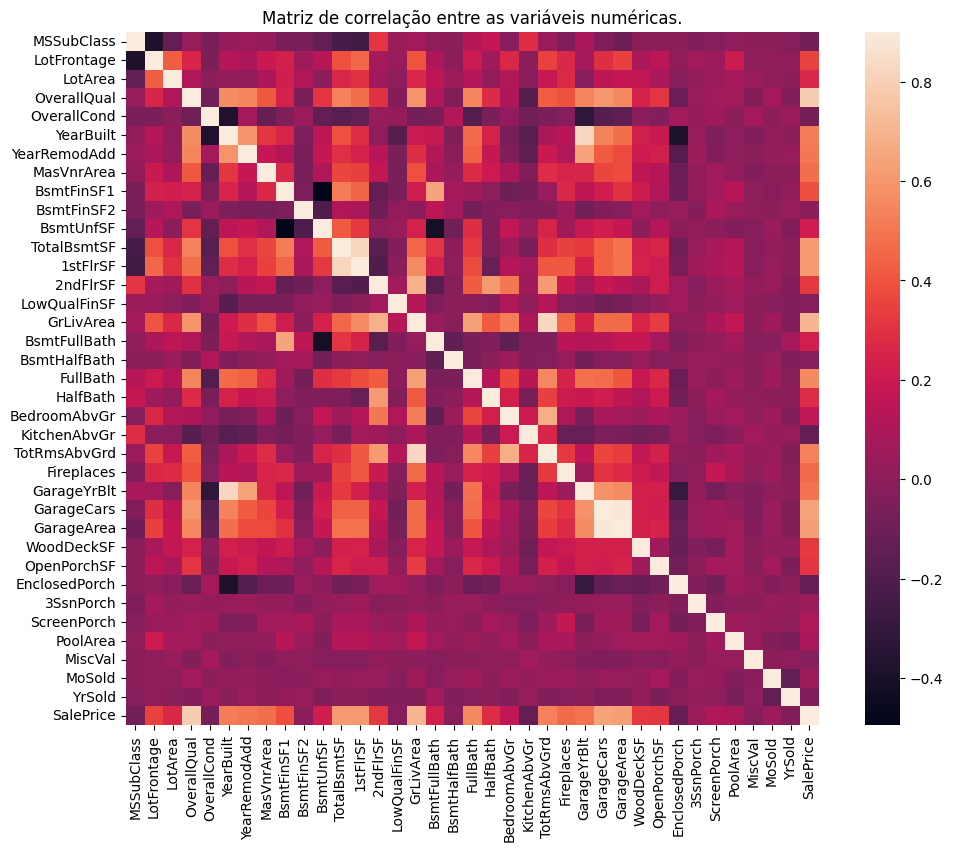

In [12]:
corr_matrix = train[numerical_features].corr()
plt.subplots(figsize=(12,9))
plt.title('Matriz de correlação entre as variáveis numéricas.')
sns.heatmap(corr_matrix, vmax=0.9, square=True)

Vamos ver quais variáveis tem correlação alta com o nosso alvo: _SalesPrice_:

In [13]:
# correlação entre as variáveis numéricas e o preço:
corr_matrix['SalePrice'].sort_values(ascending=False).head(12)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
Name: SalePrice, dtype: float64

Intuitivamente falando, é provavel que as variáveis mais correlacionadas tenham maior poder preditivo sobre o preço. Entretando devemos verificar se há correlação entre elas mesmas, para fins de simplificação, vamos pegar os atributos cuja correlação seja maior que $0.5$

<Axes: title={'center': 'Matriz de correlação entre as variáveis numéricas com correlação maior que 0.5.'}>

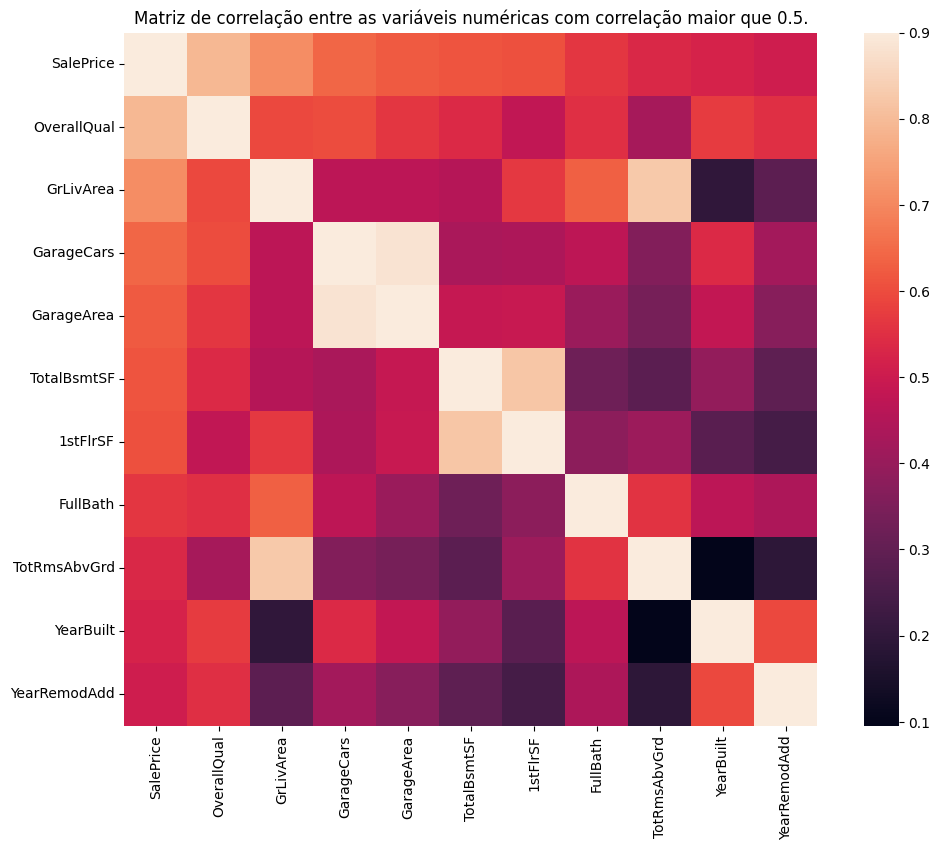

In [14]:
#atributos com correlação maior que 0.5:
features_correlated = corr_matrix['SalePrice'].sort_values(ascending=False).loc[lambda x : x > 0.5].index

#plotar a correlação entre as  variáveis com correlação maior que 0.5:
corr_matrix = train[features_correlated].corr()
plt.subplots(figsize=(12,9))
plt.title('Matriz de correlação entre as variáveis numéricas com correlação maior que 0.5.')
sns.heatmap(corr_matrix, vmax=0.9, square=True)


In [15]:

#scatterplot para colunas selecionadas:
# sns.set()

# sns.pairplot(train[features_correlated], size = 2.5)
# plt.show()

Observamos que algumas variáveis são fortemente correlacionadas: 
-  _GarageArea_ e _GarageCars_ : Faz sentido se pensar que o aumento do numero de carros na garagem exige uma garagem maior.

- _TotalBsmtSF_ e _1stFlrSF_: A relação entre o total de metragem do imovel com a metragem do primeiro andar também é pertinente.

- _TotRmsAbvGrd_ e _GrLivArea_: O número total de salas em relação ao tamanho da sala de estar também é pertinente


Portanto vamos deletar _1stFlrSF_, _GarageArea_ e _GrLivArea_ (Escolhidos de forma arbitrária).

In [16]:
# remover as variáveis com correlação maior que 0.5:
features_correlated = features_correlated.drop(['GarageArea', '1stFlrSF', 'GrLivArea'])
train = train.drop(['GarageArea', '1stFlrSF', 'GrLivArea'], axis='columns')
test = test.drop(['GarageArea', '1stFlrSF', 'GrLivArea'], axis='columns')

Para simplificação vamos escolher somente essas variáveis para nosso modelo:

### Todo:
- Aumentar a análise exploratoria e entender novas relações entre os dados
- Colocar variáveis Categóricas no modelo: verificar criterios, e metodos para isso.

as variáveis para o modelo são as seguintes:

In [17]:
features_correlated

Index(['SalePrice', 'OverallQual', 'GarageCars', 'TotalBsmtSF', 'FullBath',
       'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')

Vamos ver a dispersão dos dados em relação a o atributo alvo para cada atributo

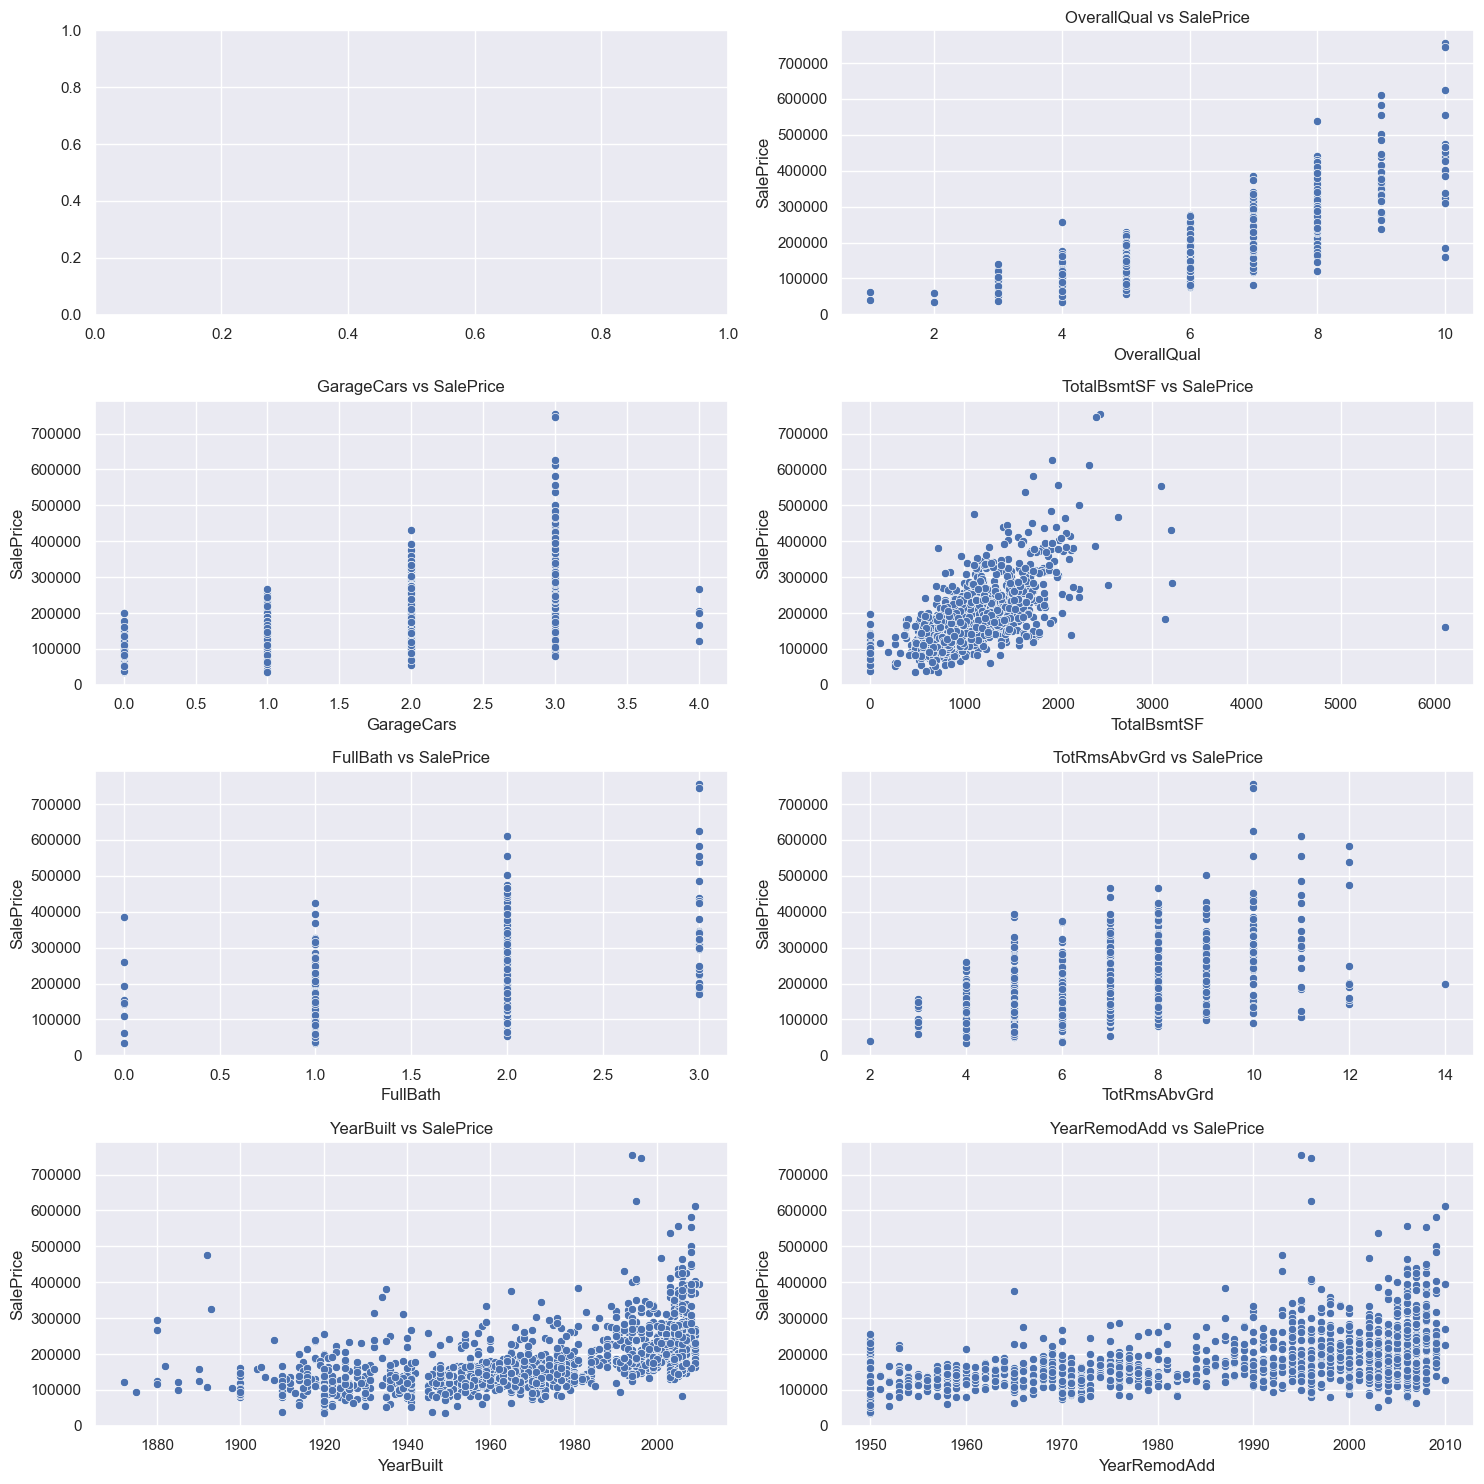

In [18]:
sns.set()


# Criar um gráfico com 4 linhas e 2 colunas
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

# Ajustar o espaçamento entre os subplots
axes = axes.flatten()

# Iterar sobre as colunas selecionadas
for i, feature in enumerate(features_correlated):
    if feature != 'SalePrice':
        ax = axes[i]
        sns.scatterplot(x=feature, y='SalePrice', data=train, ax=ax)
        ax.set_title(f'{feature} vs SalePrice')

# remover os subplots vazios:
if len(features_correlated) < len(axes):
    for j in range(len(features_correlated), len(axes)):
        fig.delaxes(axes[j])

# ajustar o espaçamento entre os subplots:
fig.tight_layout()

# Visualizar o gráfico
plt.show()

# Engenharia de Atributos
Nessa seção vamos realizar insersão de valores, e codificação de atributos

In [19]:
# numerical: discrete
discrete = [
    var for var in train.columns if train[var].dtype != 'O' and var != 'SalePrice'
    and train[var].nunique() < 10
]

# numerical: continuous
continuous = [
    var for var in train.columns
    if train[var].dtype != 'O' and var != 'SalePrice' and var not in discrete
]

# categorical
categorical = [var for var in train.columns if train[var].dtype == 'O' and train[var].nunique() > 1]

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))
print("numerical_features: ",len(numerical_features))
print("category_features: ",len(category_features))

There are 11 discrete variables
There are 22 continuous variables
There are 39 categorical variables
numerical_features:  37
category_features:  39


In [20]:
from sklearn.model_selection import train_test_split

X = train.drop(['SalePrice'], axis=1).copy()
Y = train['SalePrice'] # here we need to remove unnacessary columns if exist

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, random_state=1)

## Valores faltantes
Vamos verificar as variáveis com valores faltantes. Para as variáveis com uma porcentagem menor que 5%

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [22]:
# check if is null mean greater than 0
train_X.isnull().mean().sort_values(ascending=False).head(20)

FireplaceQu     0.470646
LotFrontage     0.183953
GarageType      0.045988
GarageYrBlt     0.045988
GarageFinish    0.045988
GarageQual      0.045988
GarageCond      0.045988
BsmtExposure    0.028376
BsmtFinType2    0.028376
BsmtQual        0.027397
BsmtCond        0.027397
BsmtFinType1    0.027397
MasVnrArea      0.005871
MasVnrType      0.005871
Electrical      0.000978
BedroomAbvGr    0.000000
HalfBath        0.000000
FullBath        0.000000
KitchenAbvGr    0.000000
BsmtHalfBath    0.000000
dtype: float64

Vamos deletar a variável _FireplaceQu_ e as demais, realizaremos um processo de inserção de dados. Para as variáveis contínuas, iremos realizar uma imputação simples pela mediana. Já para as variáveis discretas e categóricas iremos pela frequência. 

In [23]:
continuous_imputer = SimpleImputer(strategy='mean')
discrete_imputer = SimpleImputer(strategy='most_frequent')
categorical_imputer = SimpleImputer(strategy='most_frequent')

continuous_imputer.fit(train_X[continuous])
discrete_imputer.fit(train_X[discrete]) 
categorical_imputer.fit(train_X[categorical])

SimpleImputer(strategy='most_frequent')

Agora o _SimpleImputer_ aprendeu a partir dos dados de treinamento, e realizará a imputação dos valores faltantes em todo o conjunto de dados de treinamento e teste. Nessa etapa não há vazamento de informações do teste para o treino.

In [24]:
train_X[continuous] = continuous_imputer.transform(train_X[continuous])
train_X[discrete] = discrete_imputer.transform(train_X[discrete])
train_X[categorical] = categorical_imputer.transform(train_X[categorical])

test_X[continuous] = continuous_imputer.transform(test_X[continuous])
test_X[discrete] = discrete_imputer.transform(test_X[discrete])
test_X[categorical] = categorical_imputer.transform(test_X[categorical])


Verificamos que a insersção de dados foi feita corretamente.

In [25]:

train_X.isnull().mean().sort_values(ascending=False).head()

MSSubClass      0.0
MSZoning        0.0
Fireplaces      0.0
Functional      0.0
TotRmsAbvGrd    0.0
dtype: float64

In [26]:
test_X.isnull().mean().sort_values(ascending=False).head()

MSSubClass      0.0
MSZoning        0.0
Fireplaces      0.0
Functional      0.0
TotRmsAbvGrd    0.0
dtype: float64

Não há valores faltantes.

## Rare Labels
É comum encontrarmos em grandes datasets alguns atrbutos que contêm categorias raras. Para aumentar o poder preditivo dos modelos e diminuir o número de categorias, emprega-se o **RareLabel Encoding**.

In [29]:
from feature_engine import encoding as ce
rare_label_encoder = ce.RareLabelEncoder(
    tol=0.05, # porcentagem mínima de observações para não ser considerado raro
    n_categories=1,# numero de categorias para considerar raro
    )
rare_label_encoder.fit(train_X[categorical+discrete])


RareLabelEncoder(n_categories=1)

In [30]:
train_X[categorical+discrete] = rare_label_encoder.transform(train_X[categorical+discrete])
test_X[categorical+discrete] = rare_label_encoder.transform(test_X[categorical+discrete])

Para verificar o resultado, basta procurarmos a categoria "Rare" no conjunto de dados:

In [31]:
#procurar por celulas com valore "Rare":
train_X[categorical+discrete].apply(lambda x: x.str.contains('Rare').any(), axis=1).sum()

800

## Conversão de variáveis categóricas
Existem diversas técnicas de conversão simbólica-numérica, dentre elas as mais comuns são: codificação binária, ordinal, por frequência, e pela mediana.

Neste projeto, a opção escolhida foi a codificação ordinal, uma vez que muitas variáveis categóricas preservam algum certo de grau de progressão ou intensidade.

In [32]:
ordinal_encoder = ce.OrdinalEncoder(encoding_method='ordered',variables=categorical)
ordinal_encoder.fit(train_X,train_Y)


OrdinalEncoder(variables=['MSZoning', 'Street', 'LotShape', 'LandContour',
                          'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                          'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                          'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                          'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
                          'BsmtQual', 'BsmtCond', 'BsmtExposure',
                          'BsmtFinType1', 'BsmtFinType2', 'Heating',
                          'HeatingQC', 'CentralAir', 'Electrical',
                          'KitchenQual', ...])

In [33]:
train_X = ordinal_encoder.transform(train_X)
test_X = ordinal_encoder.transform(test_X)
train_X[categorical].head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
633,1,1,0,1,1,0,0,5,2,1,...,1,1,1,2,2,1,1,2,1,1
209,1,1,1,0,1,0,1,5,2,1,...,1,1,0,2,2,1,1,2,1,2
84,1,1,1,1,1,0,0,3,2,1,...,1,1,0,0,0,1,1,2,0,2
1175,1,1,1,1,1,0,0,5,2,1,...,1,1,0,0,0,1,1,2,1,2
251,1,1,1,1,1,0,0,5,2,1,...,0,0,0,2,0,1,1,2,1,2


In [34]:
train_X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
633,20.0,1,85.000000,11900.0,1,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0,0.0,4.0,2009,1,1
209,60.0,1,70.309353,14364.0,1,1,0,1,0,1,...,55.0,0.0,0.0,154.0,0,0.0,4.0,2007,1,2
84,20.0,1,80.000000,8892.0,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0,0.0,7.0,2007,0,2
1175,70.0,1,80.000000,16560.0,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0,0.0,7.0,2006,1,2
251,30.0,1,55.000000,5350.0,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0,450.0,5.0,2010,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,20.0,1,78.000000,10140.0,1,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0,0.0,8.0,2009,1,2
906,20.0,1,80.000000,9920.0,1,0,1,1,0,0,...,0.0,164.0,0.0,0.0,0,0.0,2.0,2010,1,2
1097,70.0,0,60.000000,6882.0,1,0,1,1,0,0,...,0.0,115.0,0.0,0.0,0,0.0,3.0,2007,1,2


## Outliers
Vamos verificar se há valores outliers nos atributos e vamos realizar o tratamento deles
### Identificando Outlier com Z- Score
O z-score nos da uma idéia do quanto um determinado ponto está afastado da média dos dados, isto é , ele mede quantos desvios padrão abaixo ou acima da média populacional ou amostral os dados estão:
$$
z=\frac{x-\mu}{\sigma}
$$
Onde:
- x: observação
- $\mu$: média
- $\sigma$: desvio padrão
Assumindo uma distribuição normal, sabe-se que 99,7% dos dados estão à uma distância de três desvios padrão da média. Com base nisso, será considerado nesse trabalho que dados com distância acima de três desvios padrão serão considerados outliers.

In [35]:
continuous

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal',
 'MoSold']

In [36]:
# # Filtrar apenas as colunas numéricas do DataFrame train após o drop
# # numerical_features = train.select_dtypes(include=['int64', 'float64']).columns

# # Criar uma cópia do DataFrame train
# train_ZS = train[continuous]

# # Calcular e atribuir o Z-score para cada coluna numérica, exceto a última
# for col in numerical_features[:-1]:
#     col_values = train_ZS[col].values
#     zscore = stats.zscore(col_values)  # Calcula o Z-score para todos os valores da coluna
#     outliers = (zscore > 3) | (zscore < -3)
#     train_ZS.loc[outliers, col] = np.nan

# # Criação do imputador KNN
# imputer = KNNImputer(n_neighbors=15, weights='uniform', metric='nan_euclidean')

# # Ajuste do imputador aos dados
# imputer.fit(train_ZS)

# # Imputação dos valores ausentes
# train_ZS = pd.DataFrame(imputer.transform(train_ZS), columns=train_ZS.columns)

# caminho_arquivo_excel = '../dataset/train_ZS.xlsx'
# train_ZS.to_excel(caminho_arquivo_excel, index=False)

### Identificando Outlier com Amplitude interquartil
#### Percentil
- percentil 25 : primeiro quaril
- percentil 50 : segundo quartil ou mediana
- percentil 75 : terceito quartil
#### Amplitude interquartil
É Diferença entre o terceiro quartil (Q3) e o primeiro quartil (Q1)
Para identificar Outlier rom amplitude interquartil serão realizados os procedimentos abaixo:
1. Ordenar os dados de forma crescente;
2. Calcular o valor do primeiro e terceiro quartil
3. Determinar a amplitude interquartil
4. Encontrar o limite inferior =  Q1 - 1,5*amplitude interquartil
5. Encontrar o limite superior =  Q3 + 1,5*amplitude interquartil

In [37]:
# from feature_engine.outliers import OutlierTrimmer
# # ver com Analise Exploratoria de Dados os dados que estão fora do padrão
# trimmer = OutlierTrimmer(
#     variables=continuous,
#     capping_method="iqr",
#     tail="both",
#     fold=1.5,
# )

# trimmer.fit(train_X)

In [38]:
# Criar novo DataFrame com as colunas numéricas
# Calcular o IQR e identificar outliers
for col in continuous:
    Q1 = train_X[col].quantile(0.25)
    Q3 = train_X[col].quantile(0.75)
    IQR = Q3 - Q1
    
    limIn = Q1 - (IQR * 1.5)
    limSp = Q3 + (IQR * 1.5)
    
    # Substituir outliers por np.nan
    # train_IQR.loc[(x[col] < limIn) | (train_IQR[col] > limSp), col] = np.nan
    inliers = train_X[col].between(limIn, limSp)
    train_X = train_X.loc[inliers]

    inliers = test_X[col].between(limIn, limSp)
    test_X = test_X.loc[inliers]

# Criar imputador KNN
# imputer = KNNImputer(n_neighbors=15, weights='uniform', metric='nan_euclidean')

# Ajustar imputador aos dados
# imputer.fit(train_IQR)

# Imputar valores ausentes
# train_IQR = pd.DataFrame(imputer.transform(train_IQR), columns=train_IQR.columns)

# caminho_arquivo_excel = '../dataset/train_IQR.xlsx'
# train_IQR.to_excel(caminho_arquivo_excel, index=False)

# caminho_arquivo_excel = '../dataset/train_2.xlsx'
# train[numerical_features].to_excel(caminho_arquivo_excel, index=False)

In [39]:
train_X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
633,20.0,1,85.000000,11900.0,1,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0,0.0,4.0,2009,1,1
84,20.0,1,80.000000,8892.0,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0,0.0,7.0,2007,0,2
1175,70.0,1,80.000000,16560.0,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0,0.0,7.0,2006,1,2
896,60.0,1,71.000000,7056.0,1,0,1,1,0,0,...,50.0,0.0,0.0,0.0,0,0.0,10.0,2008,1,2
77,20.0,1,70.309353,8475.0,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0,0.0,4.0,2008,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,20.0,1,108.000000,13173.0,1,1,1,1,1,0,...,102.0,0.0,0.0,0.0,0,0.0,11.0,2009,1,2
145,90.0,0,70.000000,9100.0,1,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0,0.0,11.0,2006,0,0
961,20.0,1,50.000000,7207.0,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0,0.0,2.0,2010,1,2


#### Imputando valores aos outliers
Em ambos os métodos acima, foram identificados os outliers e para cada um deles foi atribuido um valor ausente, ou seja, eles foram excluidos dos dados.
Para preencher os dados ausentes foi utilizada uma técnica de imputação de valores com base em proximidade, denominada KNN. O imputador KNN (K-Nearest Neighbors) é uma técnica dque pode ser utilizada para preencher valores ausentes em conjuntos de dados. Ele é um algoritmo de aprendizado de máquina capaz de prever valores ausentes com base na similaridade entre as amostras do conjunto de dados.

Inicialmente ele encontra os K vizinhos mais próximos (específicamente 15 nesse trabalho) para cada valor ausente, calculando a distância entre a amostra com valor ausente e todas as outras amostras no conjunto de dados. Ele seleciona as K amostras mais próximas com base em uma métrica de distância que, neste caso, é a distância euclidiana.

Em seguida, o KNN calcula um valor imputado para o valor ausente com base na média arimética dos valores dos vizinhos (vizinhos com pesos iguais). Por fim, o valor imputado é atribuído a cada valor ausente no conjunto de dados.

# Seleção de Atributos (opcional)
Nessa seção vamos realizar a seleção de atributos relevantes para o modelo.


# Treino e Teste

Nessa seção vamos treinar um modelo de regressão que gere uma predição dos valores de teste

In [40]:
# regressao linear
from sklearn.linear_model import LinearRegression

#arvore de deciao
from sklearn.tree import DecisionTreeRegressor

# SVM
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR

# Adaline
from sklearn.linear_model import SGDRegressor

#MLP
from sklearn.neural_network import MLPRegressor

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB, GaussianNB

#cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


In [41]:
new_train = train[features_correlated]

X = new_train.drop(['SalePrice'], axis=1).copy()
Y = new_train['SalePrice'] # here we need to remove unnacessary columns if exist

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, random_state=1)

In [42]:
new_train

,SalePrice,OverallQual,GarageCars,TotalBsmtSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
Id,,,,,,,,
1,208500,7,2,856,2,8,2003,2003
2,181500,6,2,1262,2,6,1976,1976
3,223500,7,2,920,2,6,2001,2002
4,140000,7,3,756,1,7,1915,1970
5,250000,8,3,1145,2,9,2000,2000
...,...,...,...,...,...,...,...,...
1456,175000,6,2,953,2,7,1999,2000
1457,210000,6,2,1542,2,7,1978,1988
1458,266500,7,1,1152,2,9,1941,2006


Separamos o dataset de treino na proporção de 70-30 em um dataset de treino e outro de teste. Perceba que o tamanho do dataset de teste realmente é 30% do dataset original.

In [252]:
print(train_X.shape, train_Y.shape)
print(test_X.shape, len(test_Y))

(1022, 7) (1022,)
(438, 7) 438


### Regressão Linear

O primeiro modelo será uma regressão linear utilizando a biblioteca do scikit-learn de linear_model importando a classe LinearRegression

In [38]:
LR = LinearRegression()
LR.fit(train_X, train_Y)

LR_predicted = LR.predict(test_X)

### Árvore de Decisão

O segundo modelo será um regressor de Árvore de Decisão utilizando a biblioteca do scikit-learn de tree importando a classe DecisionTreeRegressor

In [39]:
DTR = DecisionTreeRegressor(criterion='squared_error', max_depth=15, min_samples_split=5, min_samples_leaf=5)
DTR.fit(train_X, train_Y)

DTR_predicted = DTR.predict(test_X)

### SVM

O terceiro modelo será um SVM utilizando a biblioteca do scikit-learn de svm importando a classe SVR

In [40]:
SVM = make_pipeline(RobustScaler(), SVR(kernel='linear', C=1000))
SVM.fit(train_X, train_Y)

SVM_predicted = SVM.predict(test_X)

### Adaline - Redes Neurais

In [41]:
ADALINE = SGDRegressor(loss='huber', learning_rate='constant', eta0=0.01, max_iter=1000)
ADALINE.fit(train_X, train_Y)

ADALINE_predicted = ADALINE.predict(test_X)

### MLP - Redes Neurais

In [42]:
MLP = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=10000, random_state=42)

MLP.fit(train_X, train_Y)
MLP_predicted = MLP.predict(test_X)

### Naive Bayes

In [43]:
NB = GaussianNB(var_smoothing=1e-9)

NB.fit(train_X, train_Y)
NB_predicted = NB.predict(test_X)

# Avaliação do Modelo

Nessa seção vamos avaliar a performance do modelo gerado.

Os principais critério que vamos avaliar vão ser os seguintes:
- $R^2$:
O primeiro é o coeficiente de determinação, usualmente expresso por $R^2$. O coeficiente de determinação é a razão da variância do alvo, explicado ou predito pelo modelo, pela a variância total do alvo. É um valor com limites entre $0$ e $1$, e quanto mais próximo de 1 maior a capacidade do modelo em explicar ou prever a variância da variável alvo.
$$R^2 = \frac{\sum(\hat{y} - \bar{y})^2}{\sum(y - \bar{y})^2}$$

- $RMSE$:
A segunda métrica é o erro médio quadrático (_Mean Squared Error_). O $MSE$ é a média das diferenças entre o valor alvo predito e o valor real ao quadrado. Nesse sentido, é sempre maior que zero, e quanto menor o valor de $MSE$ maior a acurácia das predições do modelo. Nesse projeto, iremos utilizar a raiz quadrada de $MSE$, chamada de $RMSE$.
$$RMSE = \sqrt{\frac{1}{n}\sum^n_{i=1}(y_i-p_i)^2}$$


Modelo Regressão Linear:
Regressão Linear  RMSE:  40172.02930461169
Regressão Linear R2: 0.7739883057444343
Regressão Linear MAPE: 0.1640251574660918


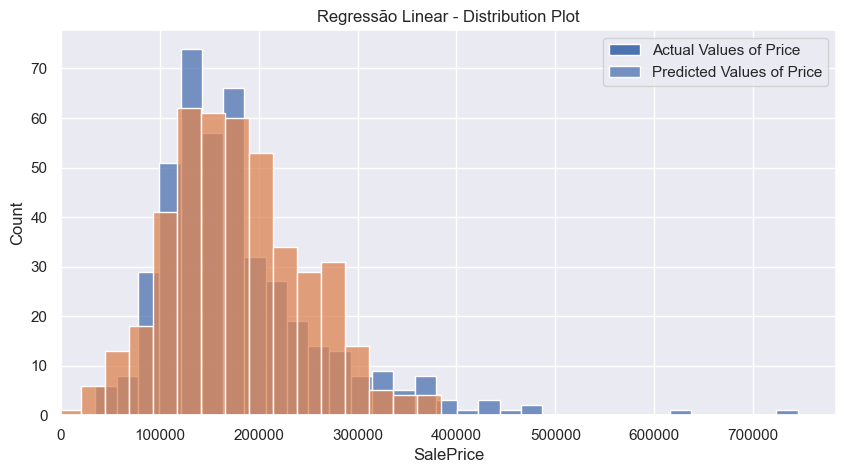

<Figure size 1200x1200 with 0 Axes>

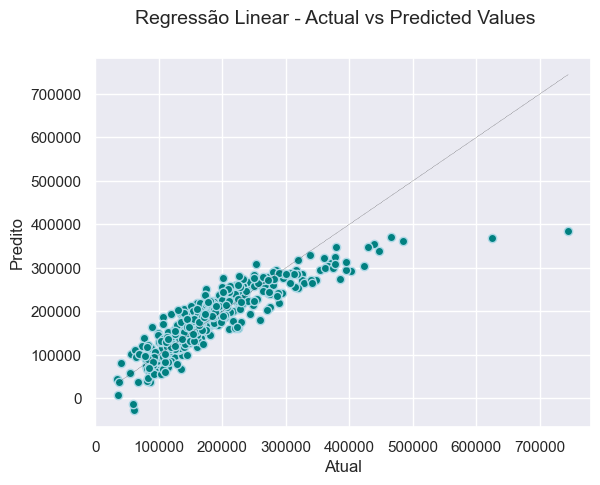

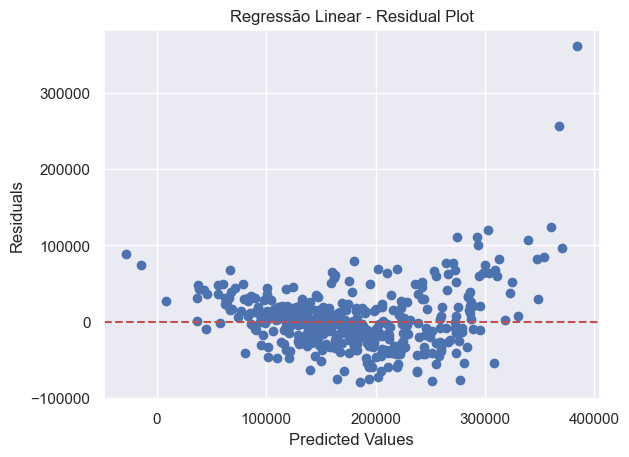


Modelo Árvore de Decisão:
Árvore de Decisão  RMSE:  37909.62169214873
Árvore de Decisão R2: 0.7987285059846485
Árvore de Decisão MAPE: 0.1640573008989713


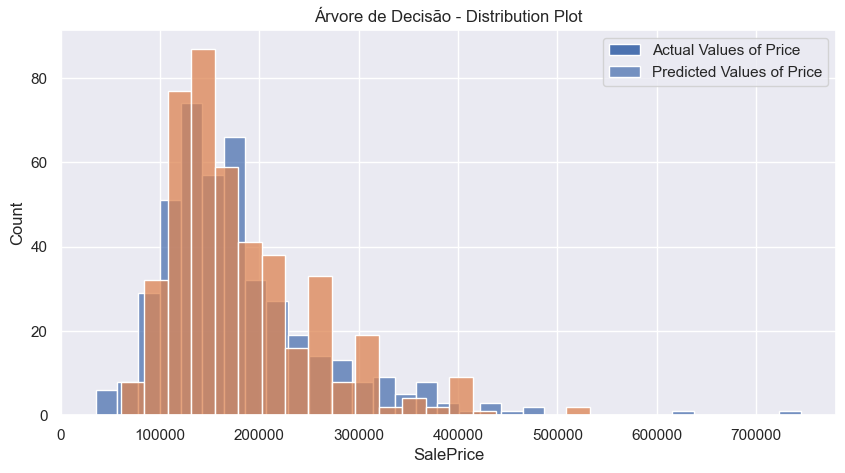

<Figure size 1200x1200 with 0 Axes>

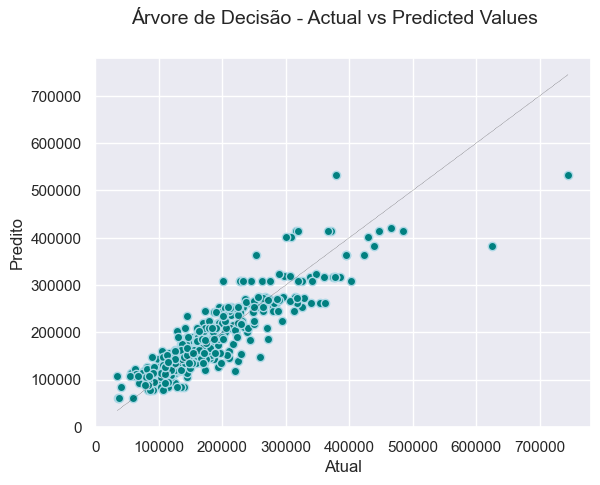

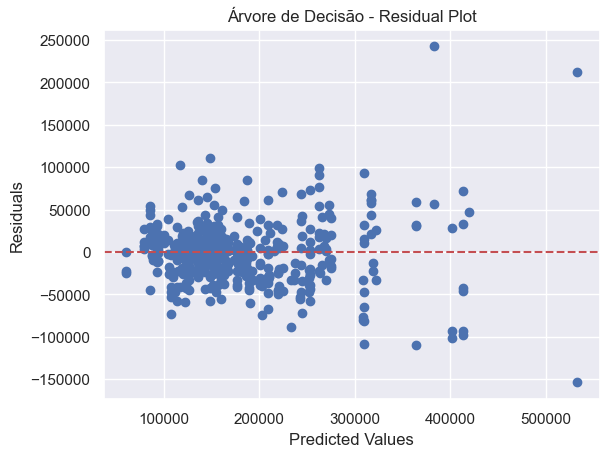


Modelo SVM:
SVM  RMSE:  43270.08540145437
SVM R2: 0.7377841896700229
SVM MAPE: 0.15088543699960844


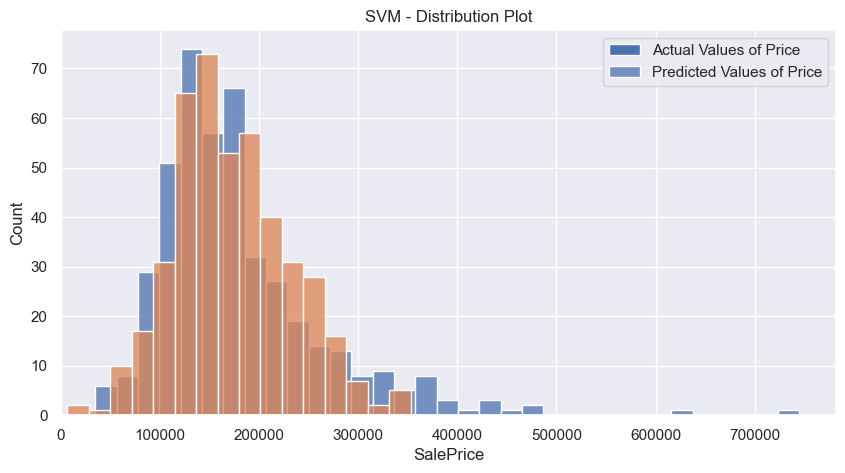

<Figure size 1200x1200 with 0 Axes>

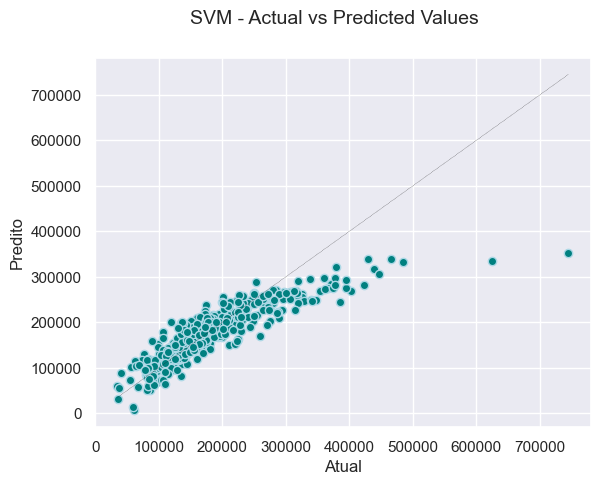

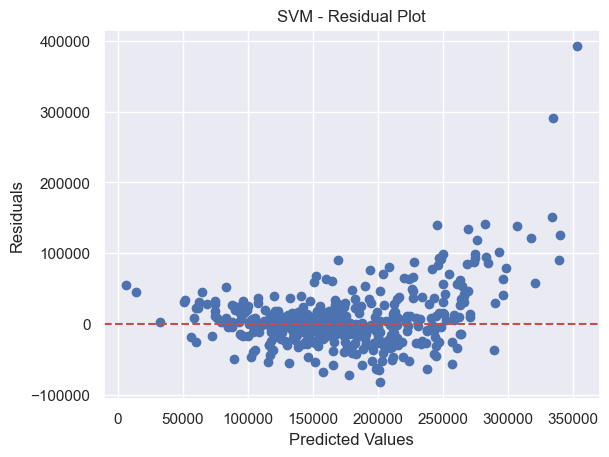


Modelo ADALINE:
ADALINE  RMSE:  69858.17898110107
ADALINE R2: 0.3165324648335772
ADALINE MAPE: 0.25686386958915697


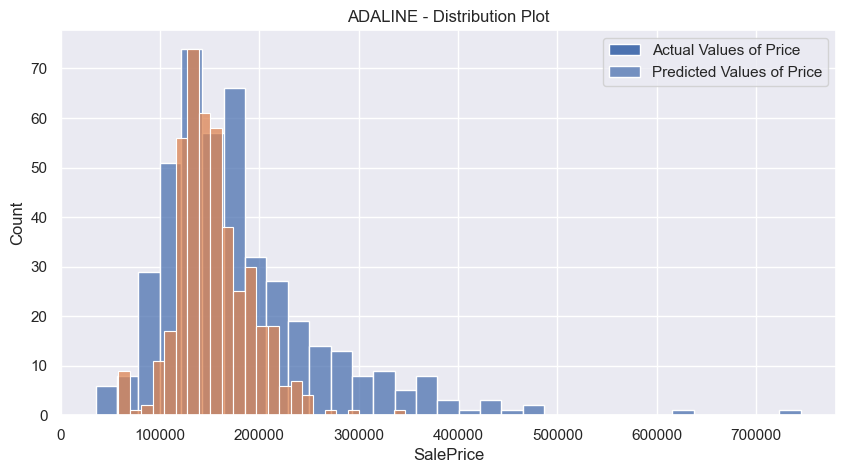

<Figure size 1200x1200 with 0 Axes>

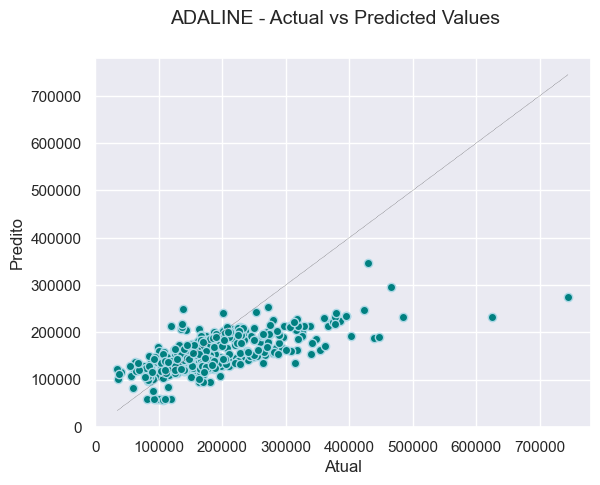

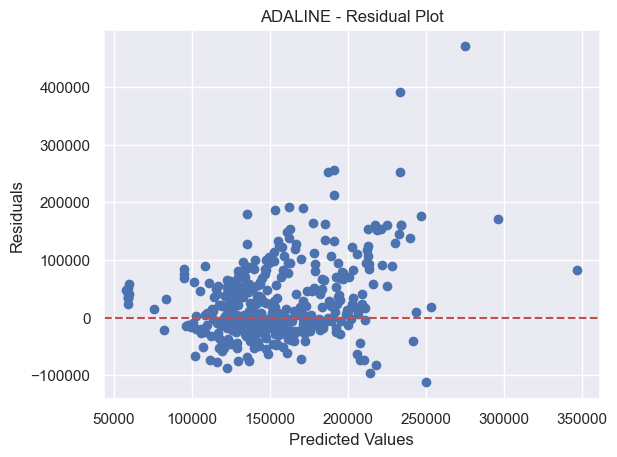


Modelo MLP:
MLP  RMSE:  62250.823920947274
MLP R2: 0.457282810677069
MLP MAPE: 0.2998241532336403


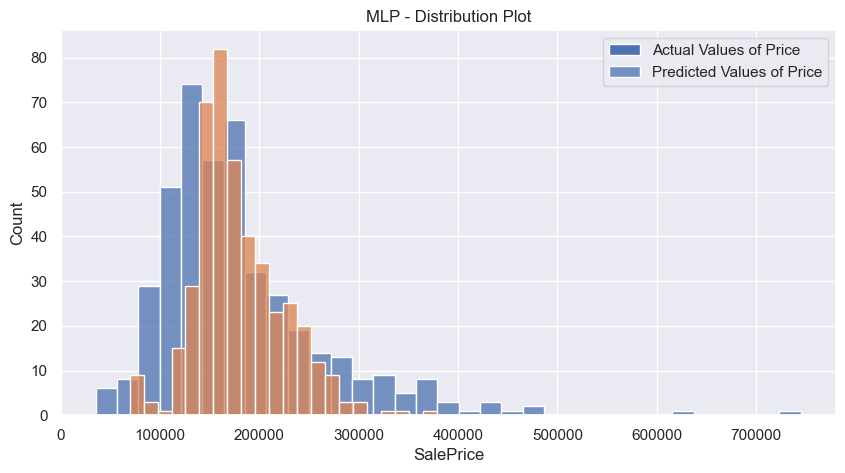

<Figure size 1200x1200 with 0 Axes>

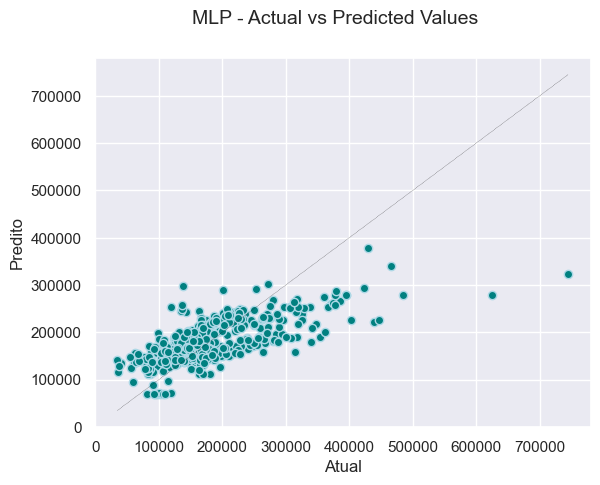

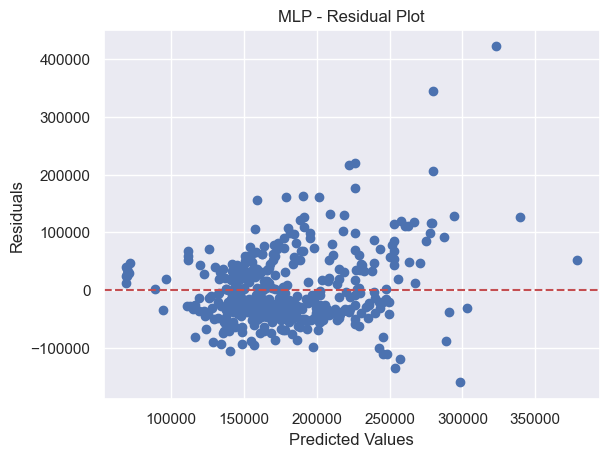


Modelo Naive Bayes:
Naive Bayes  RMSE:  48546.441365729945
Naive Bayes R2: 0.6699359918192762
Naive Bayes MAPE: 0.1980793727684145


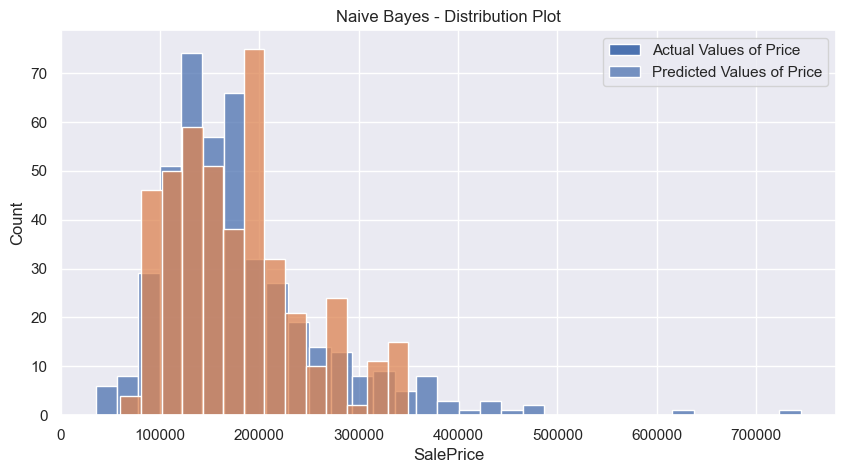

<Figure size 1200x1200 with 0 Axes>

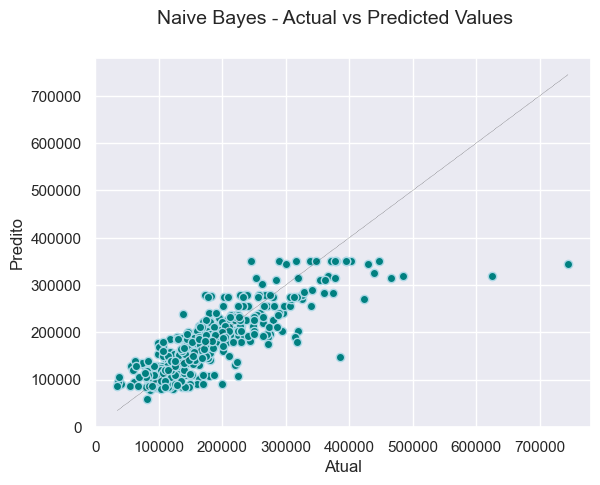

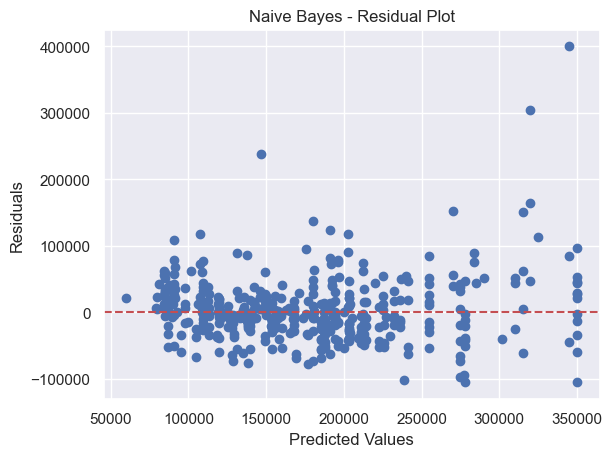

In [45]:
# avaliando
from sklearn.metrics import mean_squared_error, r2_score
from functions.actual_vs_pred_plot import actual_vs_pred_plot
from functions.model_residual_plot import model_residual_plot
from functions.regression_metrics import regression_metrics
from functions.model_dist_plot import model_dist_plot
import seaborn as sns

list_models_name = [
    "Regressão Linear",
    "Árvore de Decisão",
    "SVM",
    "ADALINE",
    "MLP",
    "Naive Bayes",
]
list_models = [LR, DTR, SVM, ADALINE, MLP, NB]
list_models_predicted = [LR_predicted, DTR_predicted, SVM_predicted, ADALINE_predicted, MLP_predicted, NB_predicted]
list_models_RMSE = []
list_models_R2 = []
list_models_MAPE = []

for i in range(0, len(list_models)):
    model_predicted = list_models_predicted[i]
    model_name = list_models_name[i]
    print("\nModelo " + model_name + ":")
    rmse, r2, mape = regression_metrics(model_predicted, test_Y,model_name)
    list_models_RMSE.append(rmse)
    list_models_R2.append(r2)
    list_models_MAPE.append(mape)

    model_dist_plot(test_Y, model_predicted, model_name)
    
    actual_vs_pred_plot(test_Y, model_predicted,model_name)

    # Create residual plot
    model_residual_plot(test_Y, model_predicted, model_name)


Comparando os valores de $MAPE$ (erro percentual absoluto médio) de cada modelo gerado, obtemos:

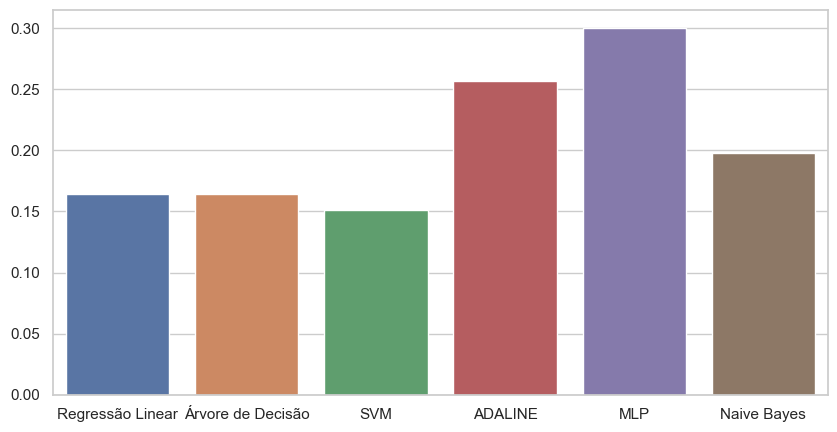

In [46]:
# comparando os modelos por MAPE:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=list_models_name, y=list_models_MAPE)

É possível perceber que SVM é o modelo que possui a menor média dos erros percentuais absolutos entre os valores preditos e os valores verdadeiros, enquanto que os modelos de Redes Neurais possuíram altas médias.

Comparando os $RMSE$ de cada modelo gerado.

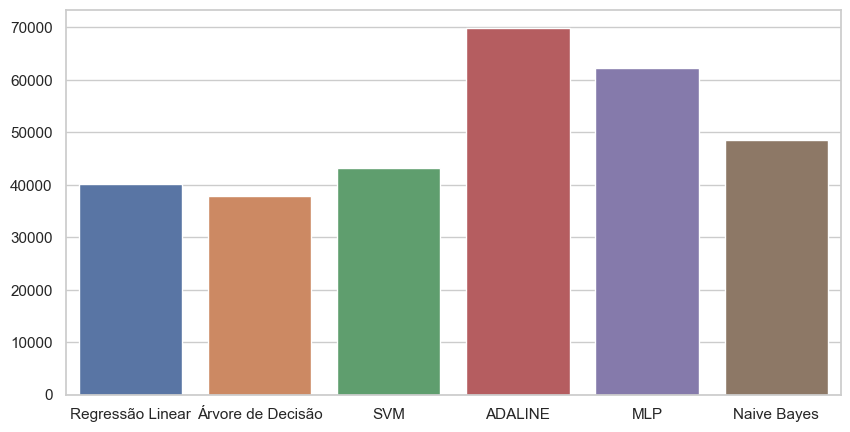

In [47]:
# comparando os modelos por RMSE:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=list_models_name, y=list_models_RMSE)

Da mesma forma, é possível perceber que Árvore de Decisão é o modelo com o menor RMSE, enquanto que novamente os modelos de redes neurais Adaline e MLP tiveram valores altos de RMSE.

Comparando os scores de $R2$ de cada modelo gerado, obtemos:

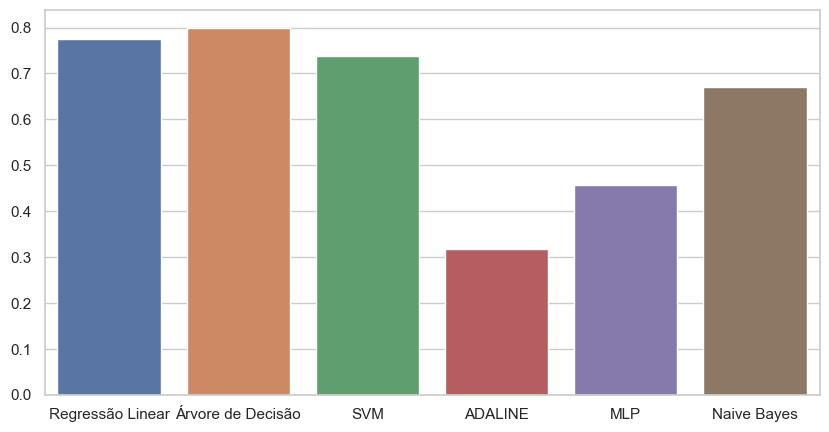

In [48]:
# comparando os modelos por R2:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=list_models_name, y=list_models_R2)

Novamente, Árvore de Decisão se destaca como o melhor modelo nesse quesito, onde quanto mais próximo de 1 é o score de R_2, melhor é o ajuste do modelo aos dados.

$ADALINE$ e $MLP$ são ambos modelos de redes neurais, sendo que a $MLP$ é mais complexa do que o $ADALINE$. Redes neurais exigem um grande volume de dados para aprender adequadamente, e podem ter desempenho abaixo do esperado se houver poucos dados de treinamento. Além disso, esses modelos podem sofrer de overfitting se não forem adequadamente configurados. Isso poderia explicar os resultados elevados de MAPE e RMSE (indicativos de erro) e baixos valores de R2 (indicativo de acurácia).

Por outro lado, o $SVM$, a $Regressão$ $Linear$ e a $Árvore$ $de$ $Decisão$ são algoritmos mais simples e menos propensos ao overfitting. O $SVM$ é especialmente conhecido por sua habilidade em lidar com espaços de alta dimensionalidade e encontrar fronteiras de decisão complexas, o que pode explicar por que ele tem o menor MAPE. No entanto, isso não significa necessariamente que ele terá o menor RMSE ou o maior R2, já que essas métricas avaliam aspectos ligeiramente diferentes do modelo. O fato de a $Árvore$ $de$ $Decisão$ ter o menor RMSE e o maior R2 pode indicar que ela está fazendo um bom trabalho de generalização.

O $Naive$ $Bayes$ faz uma suposição de independência entre os atributos que raramente é verdadeira na prática, o que pode limitar sua acurácia. Se os atributos em seus dados são altamente correlacionados (como muitas vezes acontece em dados de imóveis), isso poderia explicar por que o $Naive$ $Bayes$ não tem desempenho tão bom quanto os outros modelos, mas ainda assim é melhor do que o $ADALINE$ e o $MLP$.

Portanto, seguindo a métrica de _Root Mean Squared Error_ como a principal para fazer seleção dos modelos, o melhor modelo foi:

In [49]:
model_index = np.argmin(list_models_RMSE)
model_name = list_models_name[model_index]
model_predicted = list_models_predicted[model_index]
print("\nModelo com melhor R2: " + model_name)
print("MAPE: " + str(list_models_MAPE[model_index]))
print("RMSE: " + str(list_models_RMSE[model_index]))
print("R2: " + str(list_models_R2[model_index]))


Modelo com melhor R2: Árvore de Decisão
MAPE: 0.1640573008989713
RMSE: 37909.62169214873
R2: 0.7987285059846485


In [50]:
from sklearn.impute import SimpleImputer

melhor_modelo = list_models[model_index]

validate_columns = features_correlated.drop(['SalePrice'])
validate_df = test[validate_columns]

# Eliminate these lines after - Preprocess the data to handle missing values
# imputer = SimpleImputer(strategy='mean')
# validate_df = pd.DataFrame(imputer.fit_transform(validate_df), columns=validate_columns)

validate = validate_df.copy()
validate['SalePrice'] = melhor_modelo.predict(validate_df)

# validate

predicted_sale_price = validate
predicted_sale_price.to_csv("SalePrice_predicted.csv", index=False)
predicted_sale_price.head()

,OverallQual,GarageCars,TotalBsmtSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,SalePrice
0,5.0,1.0,882.0,1.0,5.0,1961.0,1961.0,114066.666667
1,6.0,1.0,1329.0,1.0,6.0,1958.0,1958.0,135000.000000
2,5.0,2.0,928.0,2.0,6.0,1997.0,1998.0,161728.000000
3,6.0,2.0,926.0,2.0,7.0,1998.0,1998.0,210100.000000
4,8.0,2.0,1280.0,2.0,5.0,1992.0,1992.0,200875.000000


# Implementando Pipelines e Validação cruzada

NameError: name 'Pipeline' is not defined

# Considerações finais